In [1]:
!pip install pandas
!pip install matplotlib
!pip install ipywidgets voila

In [1]:
# importing all packages
import pandas as pd
import gzip
import re
from urllib.parse import urlparse, parse_qsl, unquote
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import datetime 
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import plotly.graph_objects as go 
import plotly.express as px
import asyncio
from plotly.subplots import make_subplots

%matplotlib inline

In [2]:
#opens up fall dataset
nbgitpuller_fall23 = '/home/jovyan/discovery-su24-dataset/nbgitpuller-clicks-fall-2023.jsonl (1).gz'
nbgitpuller_fall23 = pd.read_json(gzip.open(nbgitpuller_fall23), lines = True)

In [3]:
# opens up spring dataset
nbgitpuller_filename = '/home/jovyan/discovery-su24-dataset/nbgitpuller-clicks-sp24.jsonl (2).gz'
nbgitpuller_df = pd.read_json(gzip.open(nbgitpuller_filename), lines = True)

In [4]:
# combining both datasets, spring first then fall 
nbgitpuller_df = pd.concat([nbgitpuller_df, nbgitpuller_fall23], ignore_index=True)

In [5]:
# obtaining substring after GET and before the redirection
urls_all = nbgitpuller_df.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_all = urls_all.apply(lambda x: urlparse(x))

# uses the parsed urls to obtain the action from the path
nbgitpuller_df['actions'] = urls_parsed_all.apply(lambda x: os.path.basename(x.path))

In [6]:
# function to determine the filetypes
def path_extension_puller(row):
    """
    pandas row function; uses apply
    function to pull out select file extensions and urlpaths
    """
    row_dict = dict(row)
    if 'urlpath' in row_dict:
        key = 'urlpath'
    elif 'subPath' in row_dict:
        key = 'subPath'
    else: 
        return 'NaN', 'NaN'
    
    # files that the analysis is interested in 
    file_extension_list = ['ipyn[b]?', 'Rmd', 'pdf', 'txt', 'xml', 'ini', 'csv', 'py', 'R', 'md']
    if len(row_dict[key].split('.')) > 1:
        file_extension_split_string = row_dict[key].split('.')[-1]
        for file_extension in file_extension_list:
            if (len(re.findall(file_extension, file_extension_split_string)) > 0):
                return row_dict[key], re.findall(file_extension, file_extension_split_string)[-1]
        else:
            return row_dict[key], 'NaN'
    else:
            return row_dict[key], 'NaN'

def get_repo(row):
    """
    pandas row function; uses apply
    returns repo url from parsed url
    """
    for item in row:
        key, value = item
        if 'repo' in key:
            return unquote(value)
    return 'NaN'

def repo_parsing(row):
    """
    pandas row function; uses apply
    parses the repo url so that it obtains the user and folder/content user is accessing
    """
    if row:
        if len(row[0].split('/')) > 2:
            return row[0].split('/')[1]
        else:
            return row[0].split('/')[-1]
    else:
        return 'NaN'

In [7]:
# makes a new dataframe that only contains git-pull and resets index
nbgitpuller_df_pull = nbgitpuller_df[nbgitpuller_df.actions == 'git-pull'].reset_index()

# obtains all the log info
log_info_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: ''.join(re.findall("\[.*\]", x)).replace('[', '').replace(']', '').split(' '))

# retreives the hubs for each textpayload
hub_source_pull = nbgitpuller_df_pull.resource.apply(lambda x: x['labels']['namespace_name'])

# obtains substring after GET and before the redirection
urls_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_pull = urls_pull.apply(lambda x: urlparse(x))

# uses parsed urls to obtain the action as a quality check
actions_pull = urls_parsed_pull.apply(lambda x: os.path.basename(x.path))

# breaks apart the parsed query into repo/urlpath
urls_queries_pull = urls_parsed_pull.apply(lambda x: parse_qsl(x.query))

# getting the file type from urlpath
path_extension_pull = urls_queries_pull.apply(path_extension_puller)

# gets repo urls from the parsed url
repos_pull = urls_queries_pull.apply(get_repo)

# extract ones that have github.com in the repo url or else its a null value
repos_parsed_pull = repos_pull.apply(lambda x: re.findall("github\.com/+(.+)", x) if x else 'NaN')

# obtains the user and git content from github.com repo urls
git_user_pull = repos_parsed_pull.apply(lambda x: x[0].split('/')[0] if x else 'NaN')
git_user_repo_pull = repos_parsed_pull.apply(repo_parsing)

# adds it all into a dataframe
nbgitpuller_textPayload_df_pull = pd.DataFrame({'log_info_type': log_info_pull.apply(lambda x: x[0]),
                                           'timestamp_date': log_info_pull.apply(lambda x: x[1]),
                                           'timestamp_time': log_info_pull.apply(lambda x: x[2]),
                                           'action': actions_pull,
                                           'git_query': urls_queries_pull,
                                           'repo': repos_pull,
                                           'git_user_content': repos_parsed_pull,
                                           'git_user': git_user_pull,
                                           'git_content': git_user_repo_pull,
                                           'git_path': path_extension_pull.apply(lambda x: x[0]),
                                           'file_extension': path_extension_pull.apply(lambda x: x[1]),
                                           'hub': hub_source_pull})

In [8]:
nbgitpuller_textPayload_df_pull['git_user_content_path'] = nbgitpuller_textPayload_df_pull.apply(lambda x: ''.join(x['git_user_content']) + '/' + ''.join(x['git_path']), axis = 1)

In [9]:
def course_assigner_regex(row):
    """
    pandas row function; uses apply
    determines which classes and semesters are for each github repo
    """
    courses = {'(data8|ds8)': 'data8', '(ds100|data100)': 'data100', '(prob140)': 'data140', #data
               '(caldataeng|data101|ds101)': 'data101', '(data6|ds6)': 'data6', '(data102|ds102)': 'data102', #data
               '(data4ac|ds4ac)': 'data4ac', '(data198|ds198)': 'data198',
               '(cs189|compsci189)': 'compsci189', '(cs170|compsci170)': 'compsci170', #compsci 
               '(ee16a|eecs16a)': 'eecs16a', '(ee16b|eecs16b)': 'eecs16b', '(eecs127)': 'eecs127',#eecs
               '(ee120|eleng120)': 'eleng120', #electrical engineering
               '(physics111b)': 'physics111b', '(physics88)': 'physics88', # physics
               '(polsci3|ps3|polisci3)': 'polsci3', '(polsci5|ps5)': 'polsci5', '(polsci88|ps88)': 'polsci88', '(ps109|polsci109)': 'polsci109', # polisci
               '(ce190|civeng90)': 'civgeng190', '(ce93|civeng93)': 'civeng93', '(ce200b|civeng200b)': 'civeng200b', '(ce110|civeng110)': 'civeng110', #civileng
               '(envecon118|eep118)': 'envecon118', '(eep147|envecon147)': 'envecon147', '(eep153|envecon153)': 'envecon153', #environmental
               'ph[w]?142': 'pbhlth142', 'ph[w]?251': 'pbhlth251', 'ph[w]?290': 'pbhlth290', 'ph[w]?252': 'pbhlth252', 'ph[w]?253': 'pbhlth253', 'pbhlth250c': 'pbhlth250c',
               'ph[w]?196': 'pbhlth196', # public health
               'mcb163l': 'mcellbi163l', 'mcb280': 'mcellbi280', 'mcbc117': 'mcellbic117', 'mcb32': 'mcellbi32', 'mcb288': 'mcellbi288', #molecular cell bio
               '(bio1b|biology1b)': 'biology1b', # biology
               'stat88': 'stat88', 'stat157': 'stat157', 'stat159': 'stat159', 'stat131': 'stat131', 'stat135': 'stat135', 'stat20': 'stat20', 
               'stat150': 'stat150', #stat
               'math124': 'math124', #math
               '(demog180)': 'demog180', 'demog[c]?175': 'demog175', #demography
               '(eps130)': 'eps130', '(eps88)': 'eps88', 'eps256': 'eps256', 'eps24': 'eps24',
               '(econ140)': 'econ140', '(econ148)': 'econ148', 'econ141': 'econ141', 'econ172': 'econ172', 'econ151': 'econ151', #econ
               'econ157': 'econ157', 'econ130': 'econ130', 'econ143': 'econ143', 'econ135': 'econ135',
               '(rbridge)': 'datasci_rbridge', '(midsw241)': 'datasci241', '(midsw203)': 'datasci203', #datasci
               '(legal123|legalst123)': 'legalst123', '(legalst190|legal190)': 'legalst190', # legal
               '(es22ac|ethstd22ac)': 'ethstd22ac', '(esc164a|ethstdc164a)': 'ethstdc164a', '(es21ac|ethstd21ac)': 'ethstd21ac',  # ethnic studies
               'cp201b': 'cyplan201b', '(cityplanning88|cp88)': 'cyplan88', 
               'ib120': 'integbi120', 'ibc32': 'integbi32', 'ib134l': 'integbi134l',
               'mse104l': 'matsci104l',
               'are212': 'aresec212',
               'educw142': 'educw142',
               '(cogscic131|psych123)': 'cogscic131', 'psych198': 'psych198',
               'anth[ro]?115': 'anthro115',
               'espmc167': 'espmc167', '(ibespm105)': 'espmc105',
               'ls88': 'ls88',
               'dighum101': 'dighum101', 'dighum160': 'dighum160',
               'plantbi135': 'plantbi135',
               'hist160': 'history160',
               'soc88': 'sociol88', 'sw282': 'socwel282',
               'music30': 'music30', 'artw23ac': 'artw23ac'} 
    # hard coded
    git_content_user = {'danielabrahamgit120': 'eleng120', 'evalencialopezw142': 'educw142', 'charismasacey[A-Za-z0-9]+cp201': 'cp201a'}

    #strips anything thats not a letter or number
    git_string_cleaned = re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower()
    for key in courses:
        if re.findall(key, git_string_cleaned):
            return courses[key]
    for key in git_content_user:
        if re.findall(key, git_string_cleaned):
            return git_content_user[key]
    else:
        return 'unknown'
    

In [10]:
# assigns classes/courses to each log
nbgitpuller_textPayload_df_pull['course'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(course_assigner_regex)

In [11]:
def semester_assigner_regex(row):
    """
    pandas row function; uses apply
    returns the semester of the course material if known
    """
    semester = [r'fa[ll]*\d{1,4}', r'su[mmer]*\d{1,4}', r'sp[ring]*\d{1,4}', r'\d{1,4}fa[ll]', r'\d{1,4}su[mmer]*', r'\d{1,4}sp[ring]*']
    sem_match_dict = {'sp': 'spring', 'fa': 'fall', 'su':'summer'}

    git_string_cleaned = re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower()

    year_range = [2018, datetime.datetime.now().year]

    for sem in semester:
        try:
            if re.findall(sem, git_string_cleaned):
                sem_match = re.findall(sem, git_string_cleaned)[-1]
                sem_match_split = re.split('(\d+)', sem_match)
                sem_char = re.findall('[a-z]+', sem_match)[-1]
                sem_year = re.findall('[0-9]+', sem_match)[-1]
                for key, value in sem_match_dict.items():
                    if key in sem_char and sem_match_split[-1] == '':
                        if len(sem_year) < 4:
                            if year_range[0] <= int(f'20{sem_year[-2:]}') <= year_range[1]:
                                return f'{value}20{sem_year[-2:]}'
                            else:
                                return 
                        elif len(sem_year) == 4:
                            if year_range[0] <= int(sem_year) <= year_range[1]:
                                return f'{value}{sem_year}'
                            else:
                                return 'unknown'
                    elif key in sem_char and sem_match_split[-1] != '':
                        if year_range[0] <= int(sem_year) <= year_range[1]:
                            return f'{value}{sem_year}'
                        else:
                            return 'unknown'
        except Exception as e:
            print(f"Failed findall: {e=} {sem=} {git_string_cleaned=}")
            continue
    else:
        return 'unknown'


In [12]:
# assigns a semester to each log
nbgitpuller_textPayload_df_pull['semester'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(semester_assigner_regex)

In [13]:
# transforms timestamp into one and converts from UTC to PST
nbgitpuller_textPayload_df_pull['timestamp_date_time_pst'] = pd.to_datetime(nbgitpuller_textPayload_df_pull.timestamp_date + ' ' + nbgitpuller_textPayload_df_pull.timestamp_time) - pd.Timedelta(8, unit = 'h')

In [14]:
# for ones that have NaN as their filetype, check if git_path contains r_studio
nbgitpuller_textPayload_df_pull['file_extension'] = nbgitpuller_textPayload_df_pull.apply(lambda x: 'rstudio' if 'rstudio' in x['git_path'] else x['file_extension'], axis = 1)

In [15]:
# determines if the links are github or non-github
nbgitpuller_textPayload_df_pull['abnormal'] = nbgitpuller_textPayload_df_pull.repo.apply(lambda x: 'N' if 'github.com' in x else 'Y')

In [16]:
# separates abnormal repos 
nbgitpuller_textPayload_df_pull_abnormal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'Y']
nbgitpuller_textPayload_df_pull_normal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'N']

# Overall Visualizations

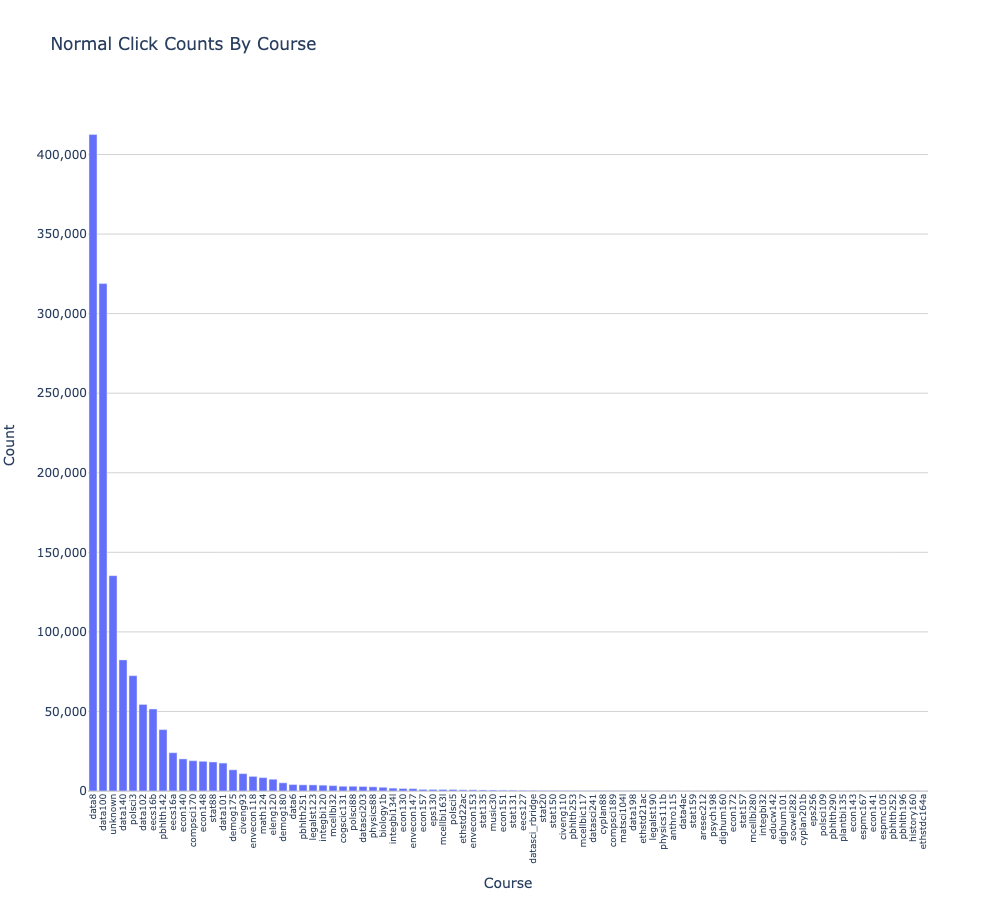

In [17]:
course_count = nbgitpuller_textPayload_df_pull_normal.course.value_counts()

fig = go.Figure(data=[go.Bar(
    x=course_count.index,
    y=course_count,
    text=None,
    textposition='outside'
)])

fig.update_layout(
    title='Normal Click Counts By Course',
    xaxis_title='Course',
    yaxis_title='Count',
    xaxis=dict(
        tickangle=-90, 
        tickmode='array',  
        tickvals=list(range(len(course_count))),  
        ticktext=course_count.index, 
        tickfont=dict(size=9)
    ),
    yaxis=dict(
        tickformat=',d', 
        gridcolor='LightGrey',  
        zerolinecolor='LightGrey'
    ),
    width=1000,  
    height=900, 
    plot_bgcolor='white', 
    paper_bgcolor='white',  
    hovermode='x unified',  
)

for trace in fig.data:
    trace.hoverinfo = 'x+y'
    trace.hoverlabel = dict(bgcolor="LightGrey", font_size=16)

fig.show()


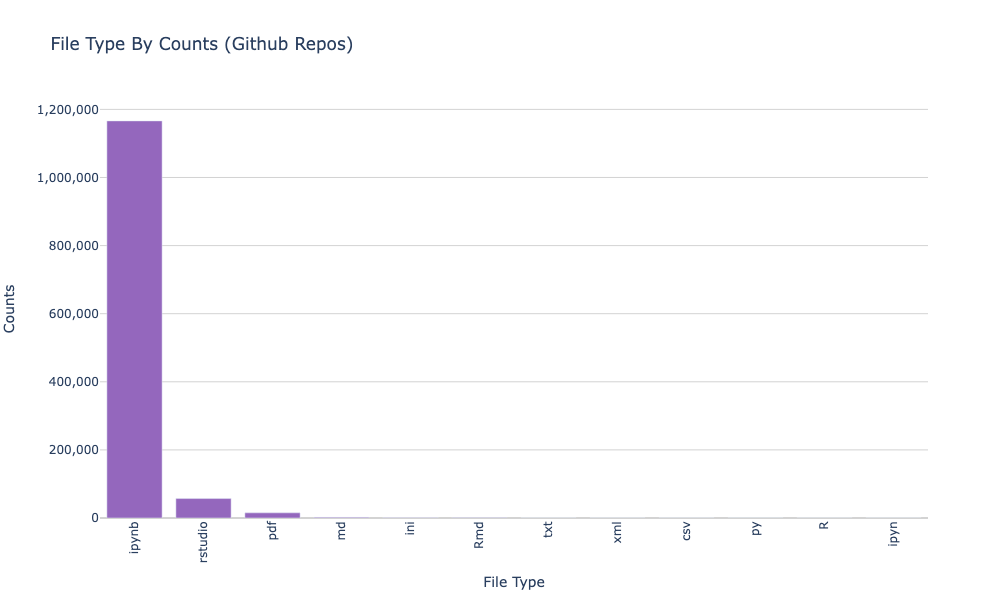

In [18]:
file_types_count = nbgitpuller_textPayload_df_pull_normal.file_extension[nbgitpuller_textPayload_df_pull_normal.file_extension != 'NaN'].value_counts()

fig = go.Figure(data=[go.Bar(
    x=file_types_count.index,
    y=file_types_count,
    text=None,
    textposition='outside', 
    marker= dict(color='#9467bd')
)])

fig.update_layout(
    title='File Type By Counts (Github Repos)',
    xaxis_title='File Type',
    yaxis_title='Counts',
    xaxis=dict(
        tickangle=-90,  
    ),
    yaxis=dict(
        tickformat=',d', 
        gridcolor='LightGrey',  
        zerolinecolor='LightGrey'
    ),
    width=900,  
    height=600, 
    plot_bgcolor='white', 
    paper_bgcolor='white',  
    hovermode='x unified',  
)

for trace in fig.data:
    trace.hoverinfo = 'x+y'
    trace.hoverlabel = dict(bgcolor="LightGrey", font_size=16)

fig.show()


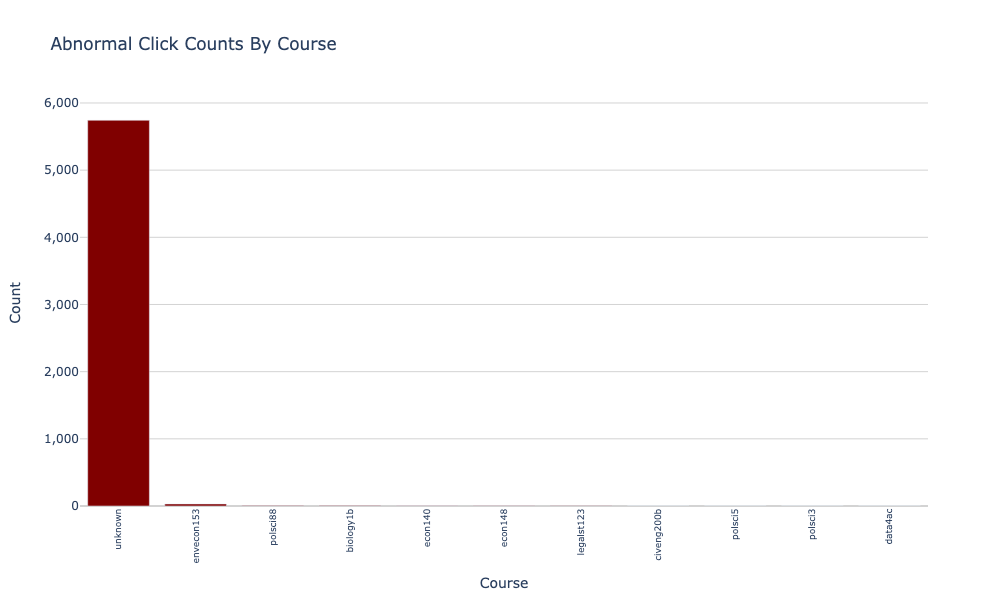

In [19]:
abnormal_course_count = nbgitpuller_textPayload_df_pull_abnormal.course.value_counts()

fig = go.Figure(data=[go.Bar(
    x=abnormal_course_count.index,
    y=abnormal_course_count,
    text=None,
    textposition='outside',
    marker=dict(color='maroon')

)])

fig.update_layout(
    title='Abnormal Click Counts By Course',
    xaxis_title='Course',
    yaxis_title='Count',
    xaxis=dict(
        tickangle=-90,  
        tickmode='array', 
        tickvals=list(range(len(abnormal_course_count))), 
        ticktext=abnormal_course_count.index, 
        tickfont=dict(size=9)
    ),
    yaxis=dict(
        tickformat=',d', 
        gridcolor='LightGrey',  
        zerolinecolor='LightGrey'
    ),
    width=800,  
    height=600, 
    plot_bgcolor='white', 
    paper_bgcolor='white',  
    hovermode='x unified',  
)

for trace in fig.data:
    trace.hoverinfo = 'x+y'
    trace.hoverlabel = dict(bgcolor="LightGrey", font_size=16)

fig.show()


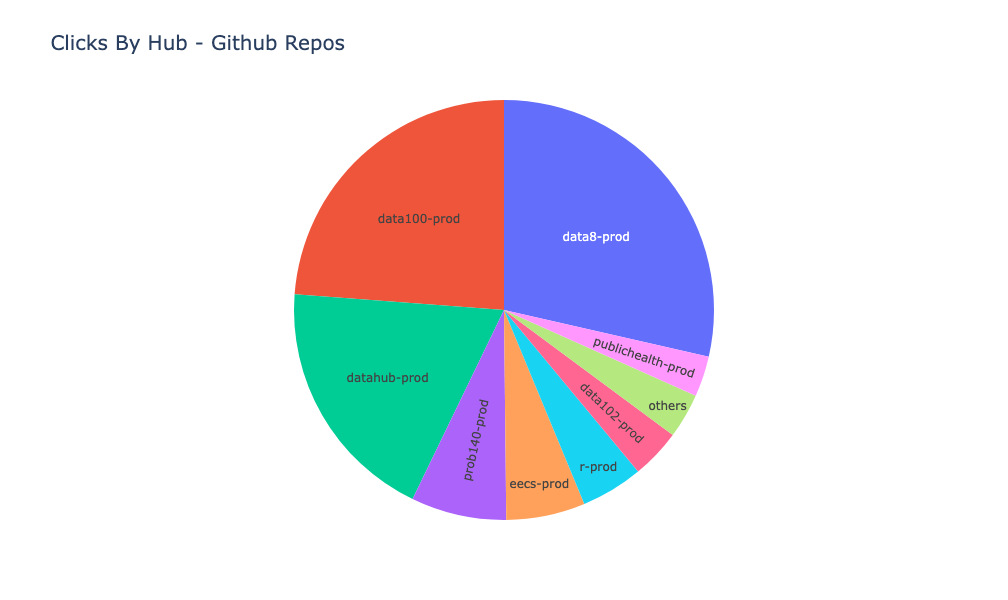

In [20]:
clicks_by_hub = nbgitpuller_textPayload_df_pull_normal.hub.value_counts()

clicks_by_hub_top8 = dict(clicks_by_hub[:8])
clicks_by_hub_top8['others'] = clicks_by_hub[8:].sum()

clicks_by_hub_top8_df = pd.DataFrame(clicks_by_hub_top8.items(), columns=['hub', 'counts'])

fig = px.pie(clicks_by_hub_top8_df, values='counts', names='hub', title='Clicks By Hub - Github Repos')

fig.update_traces(
    textinfo='label',  
    hoverinfo='label+percent+value',  
    hovertemplate='<b>%{label}</b><br>Percentage: %{percent:.2%}<br>Count: %{value}<extra></extra>'
)

fig.update_layout(
    width=800,  
    height=600, 
    title_font_size=20,
    showlegend=False
)
fig.show()

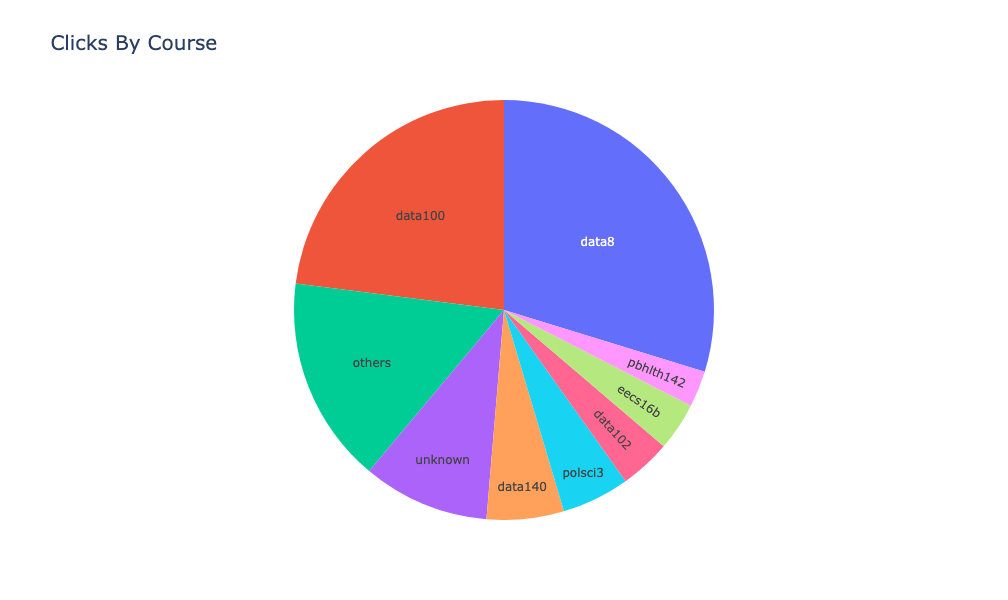

In [21]:
courses_top8 = dict(course_count[:8])
courses_top8['others'] = course_count[8:].sum()
courses_top8_df = pd.DataFrame(courses_top8.items(), columns = ['course', 'counts'])

fig = px.pie(courses_top8_df, values='counts', names='course', title='Clicks By Course')

fig.update_traces(
    textinfo='label',  
    hoverinfo='label+percent',  
    hovertemplate='<b>%{label}</b><br>Percentage: %{percent:.2%}<br>Count: %{value}<extra></extra>'
)

fig.update_layout(
    width=800,  
    height=600, 
    title_font_size=20, 
    showlegend=False
)
fig.show()

## Distributions By Semester

In [22]:
#sort df by semester 
#give sem intrinsic numerical value
sem_order = ["spring2024", "fall2023", "summer2023", "spring2023", "fall2022", "summer2022", "spring2022", "fall2021", "summer2021", "spring2021", "fall2020", "summer2020", "spring2020", "fall2019", "summer2019", "spring2019", "unknown"]
nbgitpuller_textPayload_df_pull_normal.loc[:, "semester"] = pd.Categorical(
    nbgitpuller_textPayload_df_pull_normal["semester"],
    categories=sem_order,
    ordered=True
)
nbgitpuller_textPayload_df_pull_normal_sem_sort = nbgitpuller_textPayload_df_pull_normal.sort_values("semester")
sorted_sem_count = nbgitpuller_textPayload_df_pull_normal_sem_sort.semester.value_counts().reindex(sem_order)

In [23]:
agg_sem_counts = nbgitpuller_textPayload_df_pull_normal_sem_sort.groupby("semester").count().reset_index()
agg_sem_counts = agg_sem_counts.loc[:, ["semester", "log_info_type"]].rename(columns={"log_info_type":"count"})

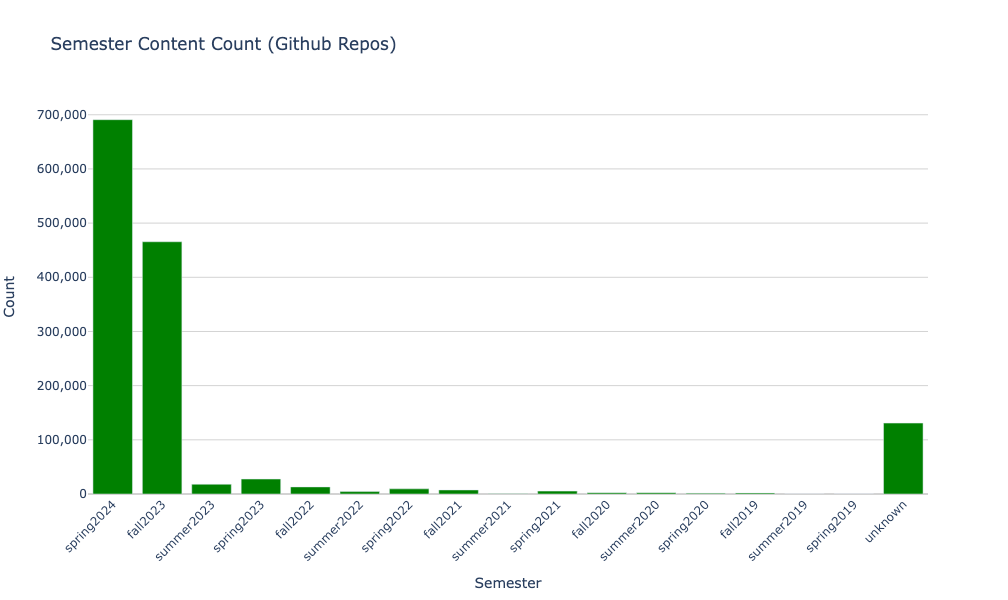

In [24]:
fig = go.Figure(data=[go.Bar(
    x=agg_sem_counts['semester'], 
    y=agg_sem_counts['count'], 
    text=None,
    textposition='outside', 
    marker= dict(color='green')
)])

fig.update_layout(
    title='Semester Content Count (Github Repos)',
    xaxis_title='Semester',
    yaxis_title='Count',
    xaxis=dict(
        tickangle=-45, 
        categoryarray=sem_order,
    ),
    yaxis=dict(
        tickformat=',d', 
        gridcolor='LightGrey',  
        zerolinecolor='LightGrey'
    ),
    width=800,  
    height=600, 
    plot_bgcolor='white', 
    paper_bgcolor='white',  
    hovermode='x unified',  
)

for trace in fig.data:
    trace.hoverinfo = 'x+y'
    trace.hoverlabel = dict(bgcolor="LightGrey", font_size=16)

fig.show()

In [25]:
def format_semester(semester):
    if semester == "Unknown": 
        return "Unknown"
    else: 
        season = semester[:-4].capitalize()
        year = semester[-4:]
        return f"{season} {year}"

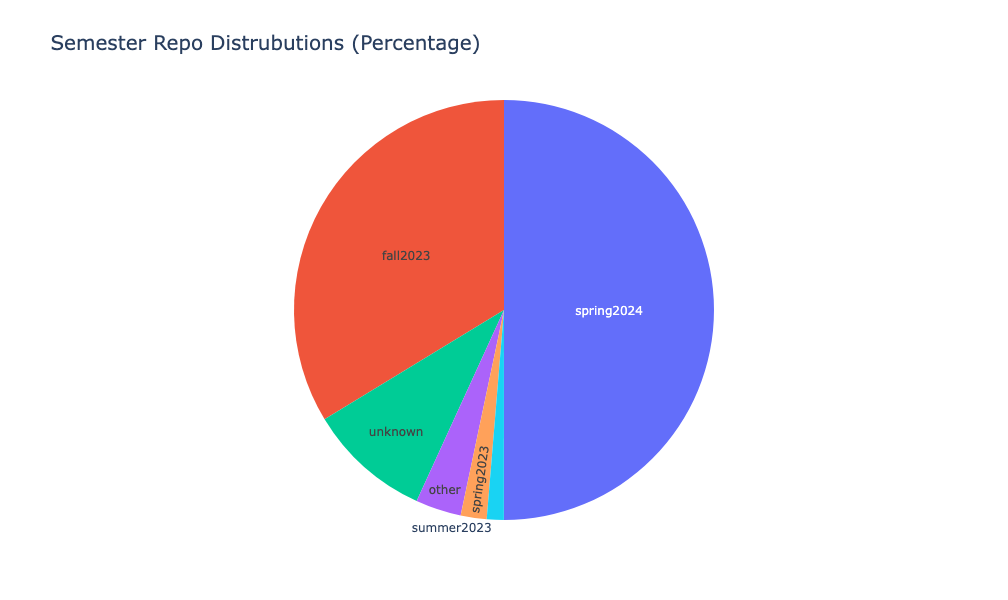

In [26]:
sem_count = nbgitpuller_textPayload_df_pull_normal.semester.value_counts()
sem_count5 = dict(sem_count[:5])
sem_count5['other'] = sem_count[5:].sum()
sem_count5 = pd.DataFrame(sem_count5.items(), columns = ['semester', 'counts'])

fig = px.pie(sem_count5, values = 'counts', names='semester', title='Semester Repo Distrubutions (Percentage)')

fig.update_traces(
    textinfo='label',  
    hoverinfo='label+percent',  
    hovertemplate='<b>%{label}</b>: %{percent:.2%}'
)

fig.update_layout(
    width=800,  
    height=600, 
    title_font_size=20,
    showlegend=False
)
fig.show()

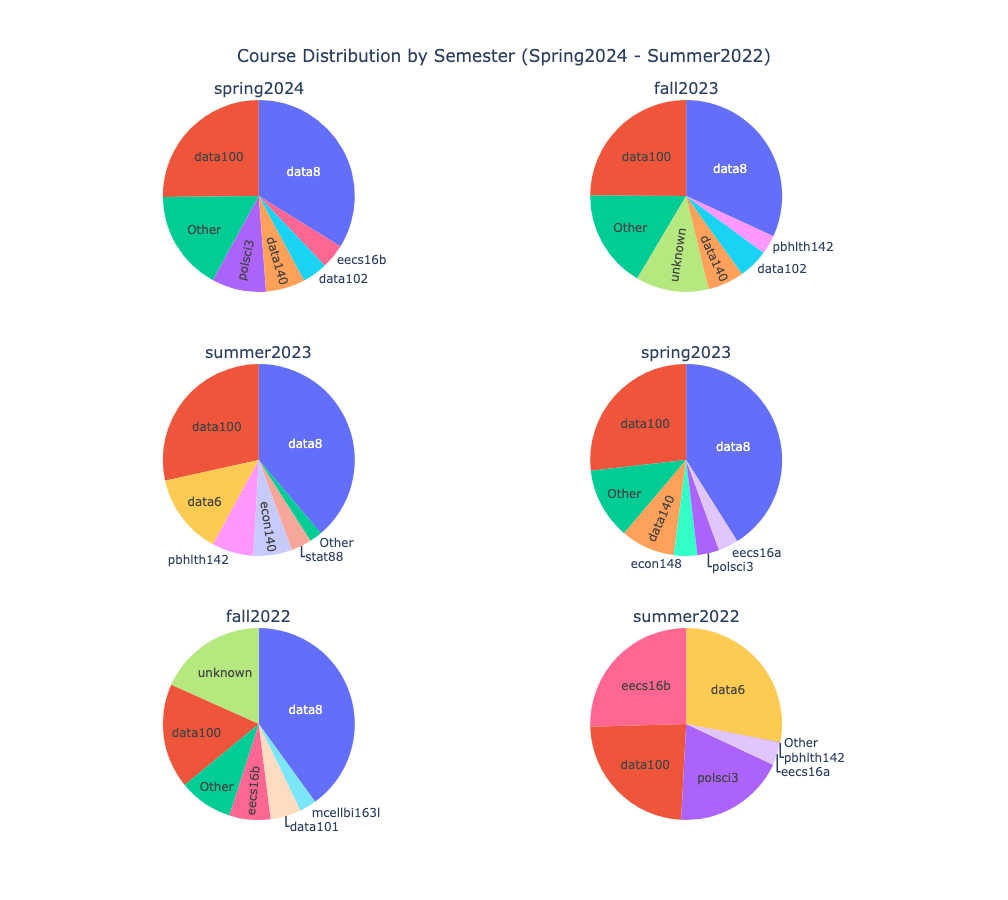

In [27]:
unique_sem = ['spring2024', 'fall2023', 'summer2023', 'spring2023', 'fall2022', 'summer2022']

rows = len(unique_sem) // 2 + len(unique_sem) % 2 

fig = make_subplots(
    rows=rows, 
    cols=2, 
    subplot_titles=unique_sem, 
    specs=[[{'type':'domain'}]*2]*rows, 
    vertical_spacing=0.1
)

for i, semester in enumerate(unique_sem):
    filtered_sem = nbgitpuller_textPayload_df_pull_normal_sem_sort[
        nbgitpuller_textPayload_df_pull_normal_sem_sort['semester'] == semester
    ]
    semester_dist = filtered_sem['course'].value_counts()[:6]
    sem_other = filtered_sem['course'].value_counts()[6:].sum()
    semester_dist['Other'] = sem_other
    
    row = i // 2 + 1 
    col = i % 2 + 1 
    fig.add_trace(go.Pie(
        labels=semester_dist.index, 
        values=semester_dist.values, 
        name=semester, 
        textinfo='label',
        hoverinfo='label+percent+value'  
    ), row=row, col=col)

fig.update_layout(
    title=dict(
        text="Course Distribution by Semester (Spring2024 - Summer2022)",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ), 
    height=300 * rows,
    showlegend=False,     
)

fig.show()

## Trends Over Time

In [28]:
courses_data = nbgitpuller_textPayload_df_pull_normal.groupby("timestamp_date").count()

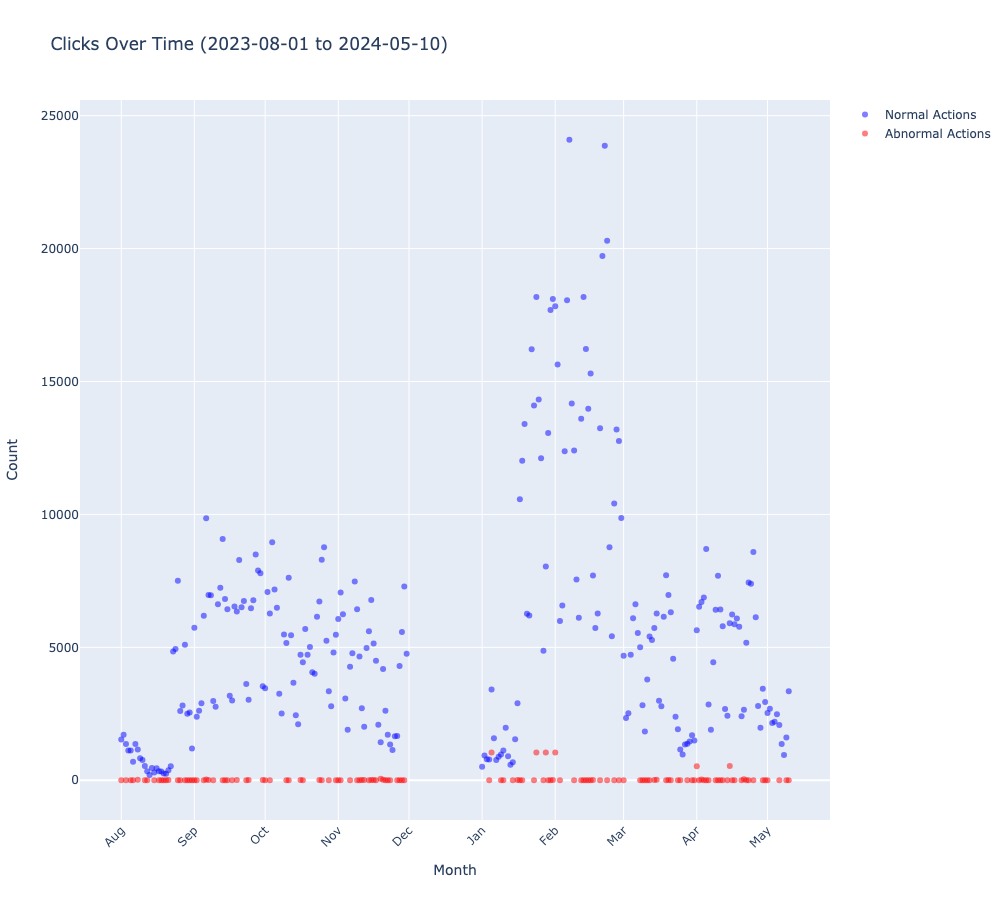

In [29]:
courses_data_abnormal = nbgitpuller_textPayload_df_pull_abnormal.groupby("timestamp_date").count()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=courses_data.index,
    y=courses_data['action'],
    mode='markers',
    name='Normal Actions',
    hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br><b>Action Count:</b> %{y}<extra></extra>',
    marker=dict(color='rgba(0, 0, 255, 0.5)')
))

fig.add_trace(go.Scatter(
    x=courses_data_abnormal.index,
    y=courses_data_abnormal['action'],
    mode='markers',
    name='Abnormal Actions',
    hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br><b>Action Count:</b> %{y}<extra></extra>',
    marker=dict(color='rgba(255, 0, 0, 0.5)')
))

fig.update_layout(
    title=f'Clicks Over Time ({courses_data.index[0]} to {courses_data.index[-1]})',
    xaxis_title='Month',
    yaxis_title='Count',
    xaxis=dict(
        tickangle=-45,
        tickformat='%b',
        tickvals=[d.strftime('%Y-%m-%d') for d in pd.date_range(start=courses_data.index[0], end=courses_data.index[-1], freq='MS')]
    ),
    yaxis=dict(
        tickformat='d'
    ),
    width=1100,
    height=900
)

fig.show()

In [38]:
agg_course_date= nbgitpuller_textPayload_df_pull_normal.timestamp_date.value_counts()
agg_course_date = pd.DataFrame(agg_course_date)
agg_course_date = agg_course_date.reset_index()
top_freq = agg_course_date.sort_values('count', ascending=False)
top_freq = top_freq.iloc[:4]

timestamp_date  count
0     2024-02-07  24094
1     2024-02-22  23868
2     2024-02-23  20292
3     2024-02-21  19722

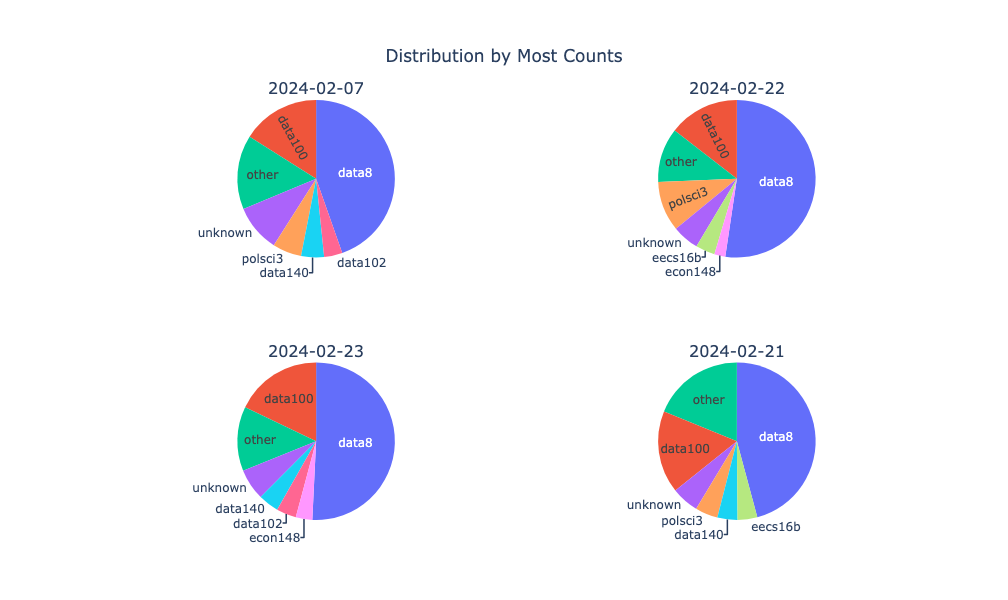

In [54]:
rows = (len(top_freq.timestamp_date) + 1) // 2

fig = make_subplots(
    rows=rows, 
    cols=2, 
    subplot_titles=[date for date in top_freq.timestamp_date],
    specs=[[{'type': 'domain'}, {'type': 'domain'}] for _ in range(rows)]
)

for i, date in enumerate(top_freq.timestamp_date):
    filtered_date = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal['timestamp_date'] == date]
    date_dist = filtered_date['course'].value_counts()[:6]
    date_other = filtered_date['course'].value_counts()[6:].sum()
    if date_other > 0:
        date_dist['other'] = date_other
    
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(go.Pie(
        labels=date_dist.index,
        values=date_dist.values,
        textinfo='label',
        hoverinfo='label+percent'
    ), row=row, col=col)

fig.update_layout(
    title=dict(
        text="Distribution by Most Counts",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    height=300 * rows,
    showlegend=False,
)

fig.show()

## Usage Frequency

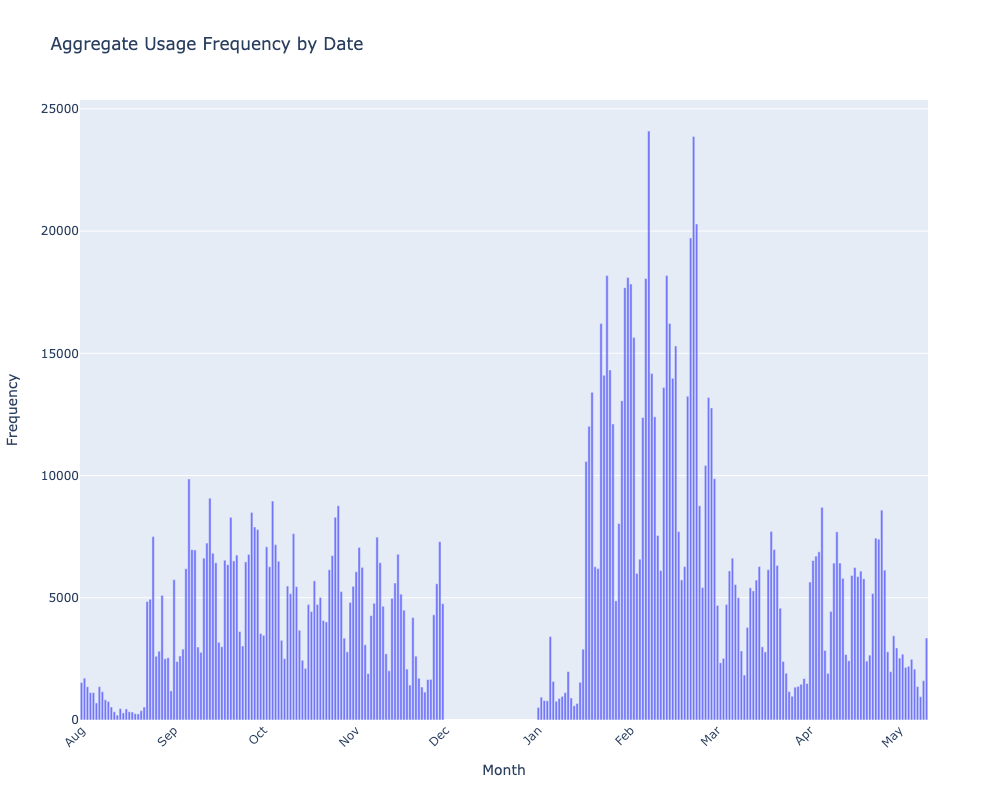

In [41]:
agg_course_date['timestamp_date'] = pd.to_datetime(agg_course_date['timestamp_date'])

agg_course_date['month'] = agg_course_date['timestamp_date'].dt.strftime('%b-%Y')
unique_months = agg_course_date['month'].unique()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=agg_course_date['timestamp_date'],
    y=agg_course_date['count'],
    marker=dict(color='rgba(0, 0, 255, 0.5)'),
    hoverinfo='x+y',
    hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br><b>Count:</b> %{y}<extra></extra>',

))

fig.update_layout(
    title='Aggregate Usage Frequency by Date',
    xaxis_title='Month',
    yaxis_title='Frequency',
    xaxis=dict(
        tickangle=-45,
        tickformat='%b',
        tickvals=[d.strftime('%Y-%m-%d') for d in pd.date_range(start=agg_course_date['timestamp_date'].min(), end=agg_course_date['timestamp_date'].max(), freq='MS')]
    ),
    yaxis=dict(
        tickformat='d'
    ),
    hovermode='x',
    width=1200,  
    height=800, 
)

fig.show()

### Usage Frequency Comparisons by Date

In [42]:
def plot_course_usage(selected_courses):
    if len(set(selected_courses)) != 5:
        print("Please select exactly 5 unique courses to display the plots.")
        return

    total_plots = len(selected_courses)
    total_columns = 5
    fig, axes = plt.subplots(1, total_columns, figsize=(25, 5))

    for k, course_name in enumerate(selected_courses):
        course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal['course'] == course_name].reset_index()
        courses_date = course.groupby(by='timestamp_date').timestamp_date.count()
        ax = axes[k]  
        ax.bar(courses_date.index, courses_date)

        ax.set_title(f'{course_name} Usage Frequency')
        ax.set_xlabel('Date')
        ax.set_ylabel('Frequency')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.tight_layout()
    plt.show()

unique_courses = sorted(nbgitpuller_textPayload_df_pull_normal['course'].unique())
course_selectors_usage = [widgets.Dropdown(
    options=unique_courses,
    value=None,
    description=f'Course {i+1}',
    disabled=False
) for i in range(5)]

output_usage = widgets.Output()

def on_selection_change_usage(change):
    with output_usage:
        output_usage.clear_output()
        selected_courses = [selector.value for selector in course_selectors_usage]
        if None in selected_courses:
            print("Please select both courses.")
        elif len(set(selected_courses)) != 5:
            print("Please select 5 unique courses.")
        else:
            plot_course_usage(selected_courses)

for selector in course_selectors_usage:
    selector.observe(on_selection_change_usage, names='value')

display(*course_selectors_usage, output_usage)

Dropdown(description='Course 1', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 2', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 3', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 4', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 5', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Output()

### Usage Frequency by Hour

In [43]:
agg_course_time= nbgitpuller_textPayload_df_pull_normal.timestamp_time.value_counts()
agg_course_time = pd.DataFrame(agg_course_time)
agg_course_time = agg_course_time.reset_index()


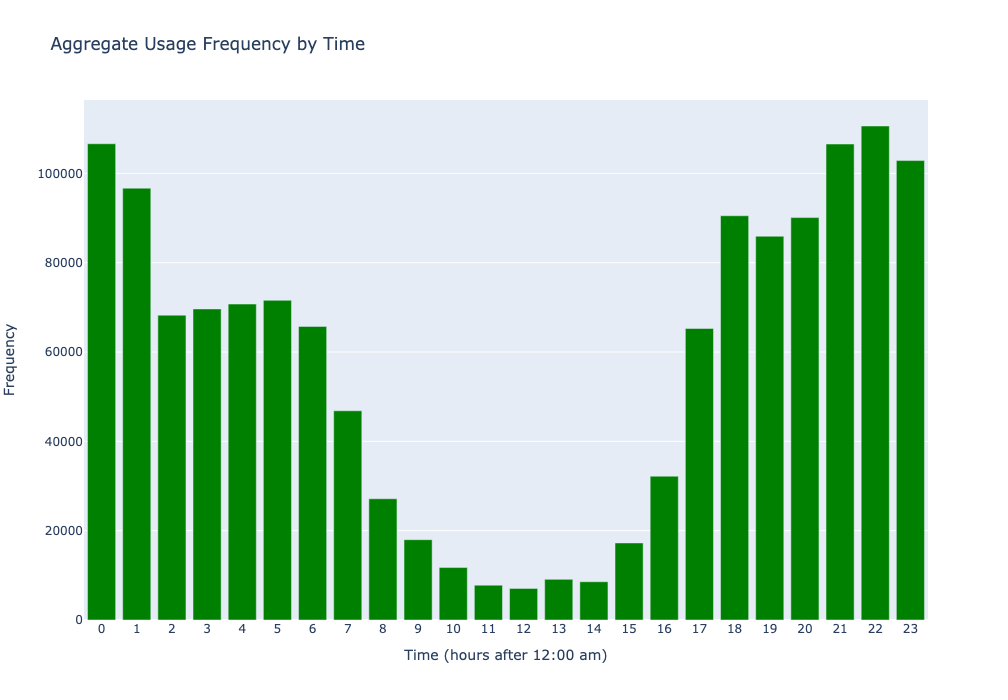

In [44]:
agg_course_time['timestamp_time'] = pd.to_datetime(agg_course_time['timestamp_time'], format='%H:%M:%S.%f')

agg_course_time['timestamp_time_hour'] = agg_course_time['timestamp_time'].dt.hour

agg_course_time_hourly = agg_course_time.groupby('timestamp_time_hour')['count'].sum().reset_index()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=agg_course_time_hourly['timestamp_time_hour'],
    y=agg_course_time_hourly['count'],
    marker=dict(color='green'),
    hoverinfo='x+y',
    hovertemplate='<b>Hour:</b> %{x}<br><b>Count:</b> %{y}<extra></extra>',
))

fig.update_layout(
    title='Aggregate Usage Frequency by Time',
    xaxis_title='Time (hours after 12:00 am)',
    yaxis_title='Frequency',
    xaxis=dict(
        tickmode='linear',  
        tick0=0,  
        dtick=1, 
    ),
    yaxis=dict(
        tickformat='d'
    ),
    hovermode='x',
    width=1000,  
    height=700, 
)

fig.show()

In [45]:
def plot_course_time_usage(time_selected_courses):
    if len(set(time_selected_courses)) != 5:
        print("Please select exactly 5 unique courses to display the plots.")
        return

    total_plots = len(time_selected_courses)
    total_columns = 5
    fig, axes = plt.subplots(1, total_columns, figsize=(25, 5))

    for k, course_name in enumerate(time_selected_courses):
        course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal['course'] == course_name].reset_index()
        course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format='%H:%M:%S.%f')
        course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
        courses_time = course.groupby(by='timestamp_time_hour').timestamp_time_hour.count()
        ax = axes[k]  
        ax.bar(courses_time.index, courses_time, color='green')

        ax.set_title(f'{course_name} Time Usage Frequency')
        ax.set_xlabel('Time (hours after 12:00 am)')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

course_selectors_time = [widgets.Dropdown(
    options=unique_courses,
    value=None,
    description=f'Course {i+1}',
    disabled=False
) for i in range(5)]

output_time = widgets.Output()

def on_selection_change_time(change):
    with output_time:
        output_time.clear_output()
        time_selected_courses = [selector.value for selector in course_selectors_time]
        if None in time_selected_courses:
            print("Please select both courses.")
        elif len(set(time_selected_courses)) != 5:
            print("Please select 5 unique courses.")
        else:
            plot_course_time_usage(time_selected_courses)

for selector in course_selectors_time:
    selector.observe(on_selection_change_time, names='value')

display(*course_selectors_time, output_time)

Dropdown(description='Course 1', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 2', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 3', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 4', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Dropdown(description='Course 5', options=('anthro115', 'aresec212', 'biology1b', 'civeng110', 'civeng93', 'cog…

Output()

# Data Science Courses Only

In [46]:
import re

In [47]:
pattern = r"^data"
data_courses_only = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal["course"].str.contains(pattern, regex=True)]

In [48]:
ds_counts = data_courses_only["course"].value_counts()

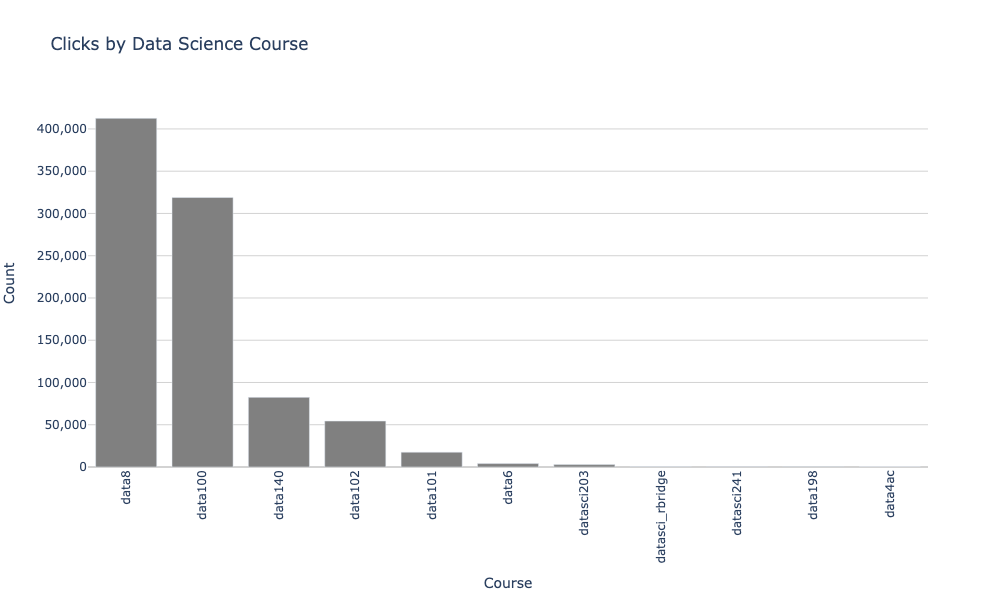

In [49]:
fig = go.Figure(data=[go.Bar(
    x=ds_counts.index,
    y=ds_counts.values,
    text=None, 
    textposition='outside',
    marker=dict(color='Grey')
)])

fig.update_layout(
    title='Clicks by Data Science Course', 
    xaxis_title='Course',
    yaxis_title='Count', 
    xaxis=dict(tickangle=-90),
    yaxis=dict(
        tickformat=',d',
        gridcolor='LightGrey',
        zerolinecolor='LightGrey'
    ),
    width=900,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='x unified',
    )

for trace in fig.data: 
    trace.hoverinfo = 'x+y'
    trace.hoverlabel = dict(bgcolor='LightGrey', font_size=16)
    
    fig.show()

In [50]:
pattern = r'(lab|hw|Homework|lec|proj|project|textbook)'

types = [re.search(pattern, path) for path in data_courses_only["git_path"]]
types = [match.group(1) if match else "unknown" for match in types]
data_courses_only["type"] = types

/tmp/ipykernel_105/1923266441.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
# NOTE: % of DS courses unaccounted for
boo = [(type == None) for type in types]
none_val = data_courses_only[boo].git_path
missing_val = sum([type == "unknown" for type in types])
percent=missing_val/len(data_courses_only)

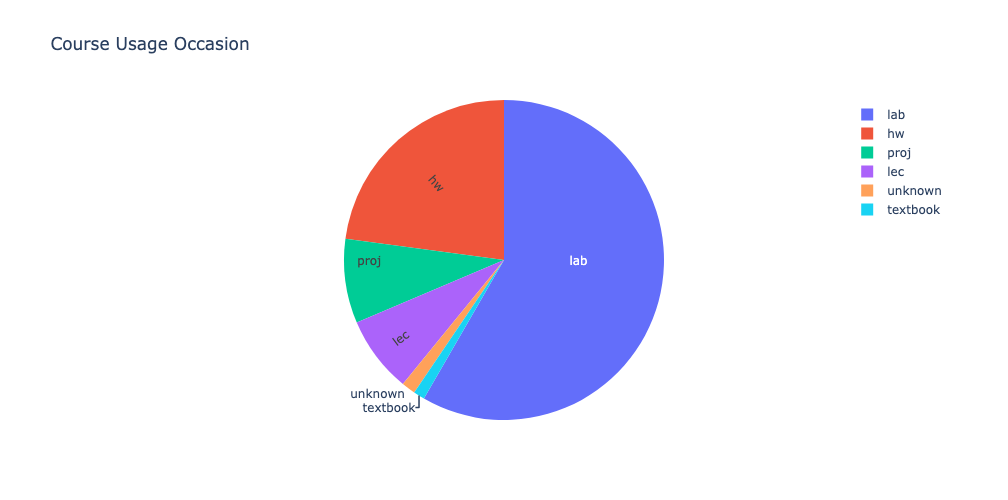

In [52]:
type_counts = data_courses_only.type.value_counts()

fig = go.Figure()

fig.add_trace(go.Pie(
    labels=type_counts.index,
    values=type_counts,
    textinfo='label',
    insidetextorientation='radial'
))

fig.update_layout(
    title='Course Usage Occasion',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

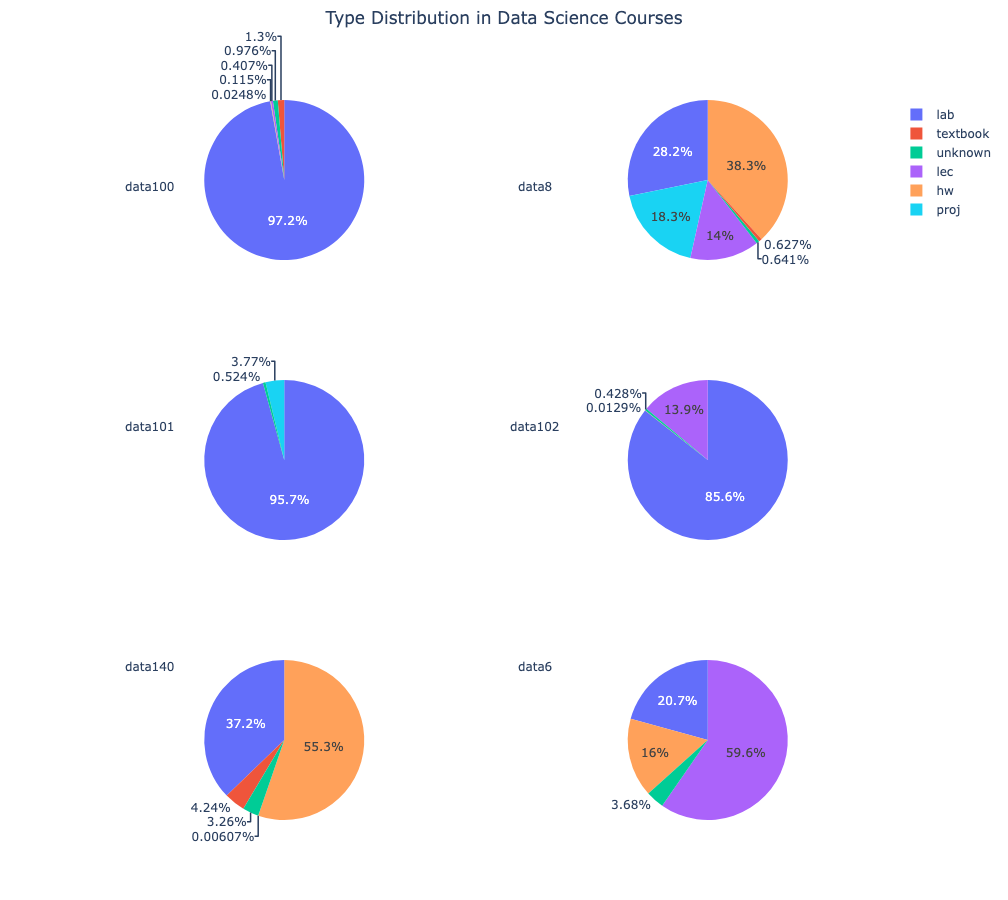

In [53]:
unique_courses = ['data100', 'data8', 'data101', 'data102', 'data140', 'data6']

rows = len(unique_courses) // 2 + len(unique_courses) % 2
fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_courses, specs=[[{'type': 'domain'}] * 2] * rows)

for i, course in enumerate(unique_courses):
    filtered_course = data_courses_only[data_courses_only["course"] == course]
    course_counts = filtered_course["type"].value_counts()

    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(go.Pie(labels=course_counts.index, values=course_counts.values, name=course, hoverinfo='label+percent'), row=row, col=col)

annotations = [
    dict(
        text=title,
        x=(col - 1) / 2 + 0.05,  
        y=(rows - row) / rows + 0.2, 
        xref='paper',
        yref='paper',
        showarrow=False,
        font=dict(size=12)
    )
    for i, title in enumerate(unique_courses)
    for row in [i // 2 + 1]
    for col in [i % 2 + 1]
]

fig.update_layout(
    title=dict(
        text='Type Distribution in Data Science Courses',
        y=0.987,  
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    height=300 * rows,  
    showlegend=True,
    annotations=annotations
)

fig.show()